In [1]:
import urllib3
import json
import requests
import pandas as pd
from ggplot import *
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [2]:
apikey = open('api.txt').readlines()[0]
forecast_URL='http://api.wunderground.com/api/' + apikey + '/hourly/q/CA/San_Francisco.json'
yesterday_URL='http://api.wunderground.com/api/' + apikey + '/yesterday/q/CA/San_Francisco.json'
today_URL='http://api.wunderground.com/api/' + apikey + '/history_' + datetime.date.today().strftime('%Y%m%d') + '/q/CA/San_Francisco.json'



forecast_data = requests.get(forecast_URL).json()
yesterday_data = requests.get(yesterday_URL).json()

today_data = requests.get(today_URL).json()


In [3]:
current_day = datetime.date.today().strftime('%d')
print(current_day)
current_hour = datetime.datetime.now().hour
print(current_hour)

31
14


In [4]:
forecast = pd.DataFrame.from_dict(forecast_data['hourly_forecast'])

#Convert Dictionary to Dataframe and grab only relevant columns
forecast = forecast[['FCTTIME','temp']]
forecast['hour'] = forecast.FCTTIME.apply(lambda x: x.get('hour'))
forecast['day'] = forecast.FCTTIME.apply(lambda x: x.get('mday'))
forecast['temp']= forecast.temp.apply(lambda x: x.get('english'))
forecast.drop(['FCTTIME'], inplace=True, axis=1)

#Get data for today
now = datetime.datetime.now()
forecast = forecast[forecast['day'] == str(now.day) ]
forecast = forecast.apply(pd.to_numeric)

#print((forecast['hour'] == 23).any())

#for i in range(0,24):
#    if (forecast['hour'] == i).any():
#        forecast = forecast.append(pd.DataFrame({'hour': i, 'day': now.day, 'temp':0}, index=[0]), ignore_index=True)



In [5]:
yesterday = yesterday_data['history']['observations']
yesterday = pd.DataFrame.from_dict(yesterday)

#Convert Dictionary to Dataframe and grab only relevant columns
yesterday = yesterday[['date','tempi']]
yesterday['hour'] = yesterday.date.apply(lambda x: x.get('hour'))
yesterday['day'] = yesterday.date.apply(lambda x: x.get('mday'))
yesterday['temp']= yesterday.tempi
yesterday.drop(['date', 'tempi'], inplace=True, axis=1)

#Remove missing data??
yesterday = yesterday[yesterday.temp != '-9999']



In [6]:
today = today_data['history']['observations']
today = pd.DataFrame.from_dict(today)

today = today[['date', 'tempi']]
today['hour'] = today.date.apply(lambda x: x.get('hour'))
today['day'] = today.date.apply(lambda x: x.get('mday'))
today['temp']= today.tempi
today.drop(['date', 'tempi'], inplace=True, axis=1)

#Remove missing data??
today = today[today.temp != '-9999']



In [16]:
#Combine Data Frame
alldata = [today, yesterday, forecast]
alldata = pd.concat(alldata)

alldata = alldata.apply(pd.to_numeric)
alldata['subject'] = 0

alldata = alldata.drop_duplicates(subset=['day', 'hour'])



widedata = alldata.pivot(index='hour', columns='day', values='temp').reset_index()
widedata['color'] = np.where(widedata[int(current_day)] > widedata[int(current_day)-1], 'red', 'blue')
widedata = widedata.interpolate()

longdata=pd.melt(widedata, id_vars=['hour', 'color'], value_vars=[30, 31], value_name='temp')
longdata.loc[longdata['day'] == int(current_day) - 1, 'color'] = "gray"

#for i in range(0, len(longdata.index)-1):
#    if ((longdata.color[i] != longdata.color[i+1]) & (longdata.color[i] != "gray")):
#        newrow=[longdata.hour[i+1], longdata.color[i], longdata.day[i], longdata.temp[i]]
#        longdata = longdata.append(pd.Series(newrow, index = list(longdata)), ignore_index=True)
        
        


ValueError: too many values to unpack (expected 2)

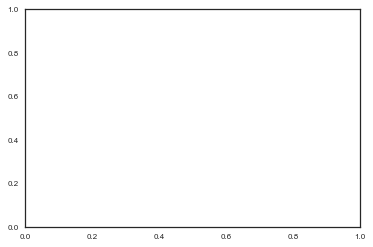

In [18]:
plt.scatter(latt, lont, c=uniqueish_color(len(latt)))


In [8]:
#tempplot = sns.tsplot(data=alldata, time='hour', condition='day', value='temp', unit='subject')

#plt.plot([current_hour, current_hour], [alldata.temp.min(), alldata.temp.max()] , linewidth=2, linestyle=":", color="gray")

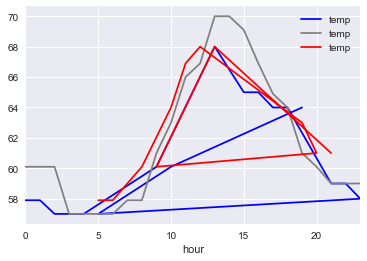

In [9]:
grouped = longdata.groupby('color')
fig, ax = plt.subplots(1)

for key, group in grouped:
   group.plot(ax=ax, x="hour", y="temp", color=key)


longdata['subject'] = 0
#tempplot = sns.tsplot(data=longdata, time='hour', condition='day', value='temp', unit='subject', hue='color')


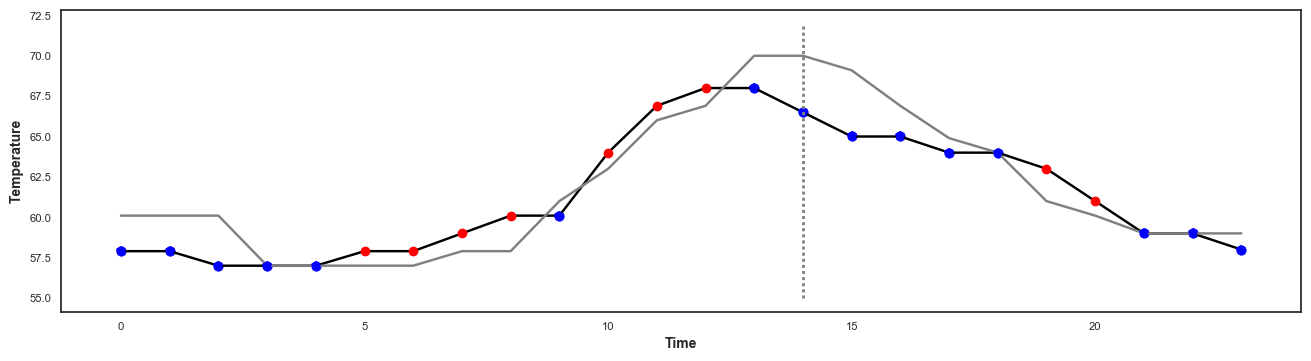

In [27]:
plt.style.use('seaborn-white')

plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


# Set an aspect ratio
width, height = plt.figaspect(.25)
fig, ax = plt.subplots(figsize=(width,height), dpi=100)

ax.plot(longdata.loc[longdata['day'] == int(current_day), 'hour'], longdata.loc[longdata['day'] == int(current_day), 'temp'], color="black")
ax.plot(longdata.loc[longdata['day'] == int(current_day)-1, 'hour'], longdata.loc[longdata['day'] == int(current_day)-1, 'temp'], color="gray")

ax.plot(longdata.loc[longdata['color'] == 'red', 'hour'], longdata.loc[longdata['color'] == 'red', 'temp'], 'ro')
ax.plot(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'], 'bp')


plt.plot([current_hour, current_hour], [alldata.temp.min()-2, alldata.temp.max()+2] , linewidth=2, linestyle=":", color="gray")
plt.scatter(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'], c="blue")


plt.xlabel('Time')
plt.ylabel('Temperature')


# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('seaborn-white')




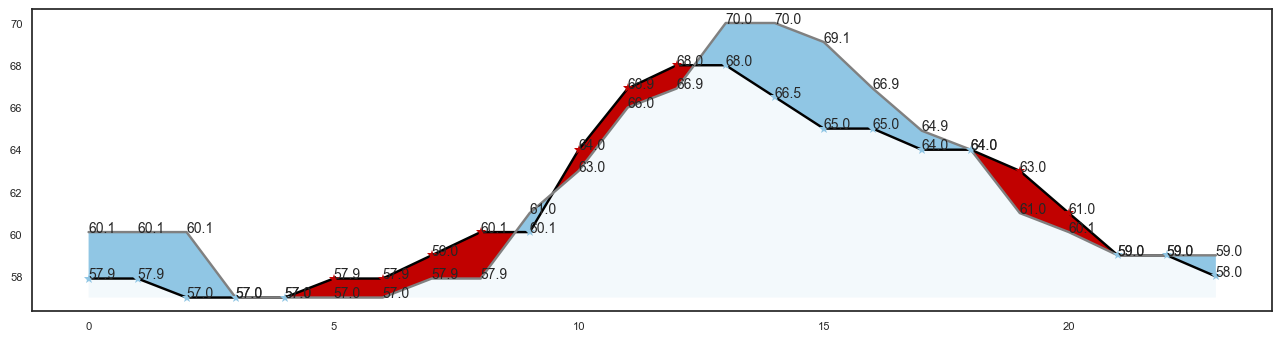

In [99]:

import matplotlib.pyplot as plt
import numpy as np


width, height = plt.figaspect(.25)
fig, ax = plt.subplots(figsize=(width,height), dpi=100)

hotter = longdata[(longdata['color'] == 'red')]
hotter = hotter.append(longdata[(longdata.hour.isin(hotter.hour.tolist())) & (longdata.day == int(current_day)-1)])

for i in range(0,23): 
    if (hotter.hour == i).any() == False:
        newrow1=[i, "red", int(current_day), np.nan]
        newrow2=[i, "gray", int(current_day)-1, np.nan]
        hotter = hotter.append(pd.Series(newrow1, index = list(longdata)), ignore_index=True)
        hotter = hotter.append(pd.Series(newrow2, index = list(longdata)), ignore_index=True)

colder = longdata[(longdata['color'] == 'blue')]
colder = colder.append(longdata[(longdata.hour.isin(colder.hour.tolist())) & (longdata.day == int(current_day)-1)])


for i in range(0,23): 
    if (colder.hour == i).any() == False:
        newrow1=[i, "blue", int(current_day), np.nan]
        newrow2=[i, "gray", int(current_day)-1, np.nan]
        colder = colder.append(pd.Series(newrow1, index = list(longdata)), ignore_index=True)
        colder = colder.append(pd.Series(newrow2, index = list(longdata)), ignore_index=True)


ax.plot(longdata.loc[longdata['day'] == int(current_day), 'hour'], longdata.loc[longdata['day'] == int(current_day), 'temp'], color="black")
ax.plot(longdata.loc[longdata['day'] == int(current_day)-1, 'hour'], longdata.loc[longdata['day'] == int(current_day)-1, 'temp'], color="gray")

                           
#ax.fill_between(colder.loc[colder.color=='gray', 'hour'], colder.loc[colder.color=='gray', 'temp'],  colder.loc[colder.color=='blue', 'temp'], color="blue",where = colder.loc[colder.color=='blue', 'temp']!=NaN) 

#ax.fill_between(hotter.loc[hotter.color=='gray', 'hour'], hotter.loc[hotter.color=='red', 'temp'],  hotter.loc[hotter.color=='gray', 'temp'], color="red")


ax.plot(longdata.loc[longdata['color'] == 'red', 'hour'], longdata.loc[longdata['color'] == 'red', 'temp'],  '*', color='#c10100')
ax.plot(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'],  '*', color='#90c6e4')

ax.fill_between(longdata.loc[longdata['day'] == int(current_day), 'hour'], \
                longdata.loc[longdata['day'] == int(current_day), 'temp'], \
                longdata.loc[longdata['day'] == int(current_day)-1, 'temp'].min(), \
                where= longdata.loc[longdata['day'] == int(current_day), 'temp'].reset_index(drop=True) >0,\
                facecolor='#f3f9fc', interpolate=True)




ax.fill_between(longdata.loc[longdata['day'] == int(current_day), 'hour'], \
                longdata.loc[longdata['day'] == int(current_day), 'temp'], \
                longdata.loc[longdata['day'] == int(current_day)-1, 'temp'], \
                where= longdata.loc[longdata['day'] == int(current_day), 'temp'].reset_index(drop=True) > longdata.loc[longdata['day'] == int(current_day)-1, 'temp'].reset_index(drop=True),\
                facecolor='#c10100', interpolate=True)

ax.fill_between(longdata.loc[longdata['day'] == int(current_day), 'hour'], \
                longdata.loc[longdata['day'] == int(current_day), 'temp'], \
                longdata.loc[longdata['day'] == int(current_day)-1, 'temp'], \
                where= longdata.loc[longdata['day'] == int(current_day), 'temp'].reset_index(drop=True) < longdata.loc[longdata['day'] == int(current_day)-1, 'temp'].reset_index(drop=True),\
                facecolor='#90c6e4', interpolate=True)

for i, txt in enumerate(longdata.temp):
    ax.annotate(txt, (longdata.hour[i],longdata.temp[i]))